In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import matplotlib.pyplot as plt


In [4]:
# --------------------------
# PATHS
# --------------------------
train_dir = "D:/DataSet/train"
test_dir  = "D:/DataSet/test"

# --------------------------
# HYPERPARAMETERS
# --------------------------
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 20
LEARNING_RATE = 1e-4



In [5]:
# --------------------------
# DATA AUGMENTATION + NORMALIZATION
# --------------------------
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.1,
    zoom_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # train verisini %20 validation olarak ayır
)



In [6]:
# --------------------------
# TRAIN / VALIDATION GENERATORS
# --------------------------
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation'
)

# --------------------------
# TEST GENERATOR
# --------------------------
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)



Found 1437 images belonging to 2 classes.
Found 359 images belonging to 2 classes.
Found 354 images belonging to 2 classes.


In [7]:
# --------------------------
# BASE MODEL
# --------------------------
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(224,224,3),
    include_top=False,
    weights='imagenet'
)

base_model.trainable = False  # pre-trained ağırlıkları koru



In [8]:

# --------------------------
# CUSTOM HEAD
# --------------------------
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

# --------------------------
# CALLBACKS
# --------------------------
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3),
    ModelCheckpoint("best_model.keras", monitor='val_loss', save_best_only=True)
]



Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
# --------------------------
# TRAIN MODEL
# --------------------------
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    callbacks=callbacks
)



Epoch 1/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 47s 945ms/step - accuracy: 0.7439 - loss: 0.5164 - val_accuracy: 0.9164 - val_loss: 0.2583 - learning_rate: 1.0000e-04
Epoch 2/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 31s 689ms/step - accuracy: 0.9193 - loss: 0.2361 - val_accuracy: 0.9220 - val_loss: 0.1796 - learning_rate: 1.0000e-04
Epoch 3/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 33s 731ms/step - accuracy: 0.9415 - loss: 0.1646 - val_accuracy: 0.9359 - val_loss: 0.1512 - learning_rate: 1.0000e-04
Epoch 4/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 33s 742ms/step - accuracy: 0.9464 - loss: 0.1560 - val_accuracy: 0.9554 - val_loss: 0.1334 - learning_rate: 1.0000e-04
Epoch 5/20
 2/45 ━━━━━━━━━━━━━━━━━━━━ 24s 578ms/step - accuracy: 0.9141 - loss: 0.1547

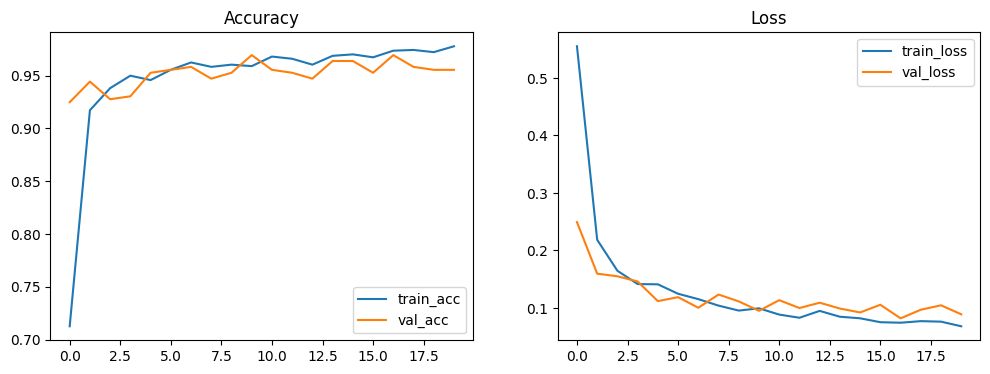

12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 399ms/step - accuracy: 0.9774 - loss: 0.0699
Test Accuracy: 0.9774011373519897


In [ ]:
# --------------------------
# PLOT ACC & LOSS
# --------------------------
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend()
plt.title('Accuracy')

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.title('Loss')
plt.show()

# --------------------------
# EVALUATE ON TEST SET
# --------------------------
test_loss, test_acc = model.evaluate(test_generator)
print("Test Accuracy:", test_acc)


In [ ]:
import cv2
import numpy as np
import random
import os
# --------------------------
# Test klasörleri
# --------------------------
cat_test_dir = "D:/DataSet/test/cat"
dog_test_dir = "D:/DataSet/test/dog"

# --------------------------
# Rastgele 10 fotoğraf seç
# --------------------------
cat_files = [os.path.join(cat_test_dir, f) for f in os.listdir(cat_test_dir)]
dog_files = [os.path.join(dog_test_dir, f) for f in os.listdir(dog_test_dir)]

all_files = cat_files + dog_files
all_labels = [0]*len(cat_files) + [1]*len(dog_files)  # 0=cat, 1=dog

# 10 rastgele seçim
indices = random.sample(range(len(all_files)), 10)
sample_files = [all_files[i] for i in indices]
sample_labels = [all_labels[i] for i in indices]

# --------------------------
# Tahmin ve görselleştirme
# --------------------------
plt.figure(figsize=(15,6))

for i, (file, true_label) in enumerate(zip(sample_files, sample_labels)):
    img = cv2.imread(file)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img, (224,224)) / 255.0
    img_input = np.expand_dims(img_resized, axis=0)
    
    pred = model.predict(img_input)[0][0]
    pred_label = 1 if pred > 0.5 else 0
    
    # Doğru mu yanlış mı
    symbol = "✔️" if pred_label == true_label else "❌"
    class_name = "Dog" if pred_label == 1 else "Cat"
    
    plt.subplot(2,5,i+1)
    plt.imshow(img)
    plt.title(f"{class_name} {symbol}")
    plt.axis('off')

plt.tight_layout()
plt.show()



NameError: name 'model' is not defined

<Figure size 1500x600 with 0 Axes>

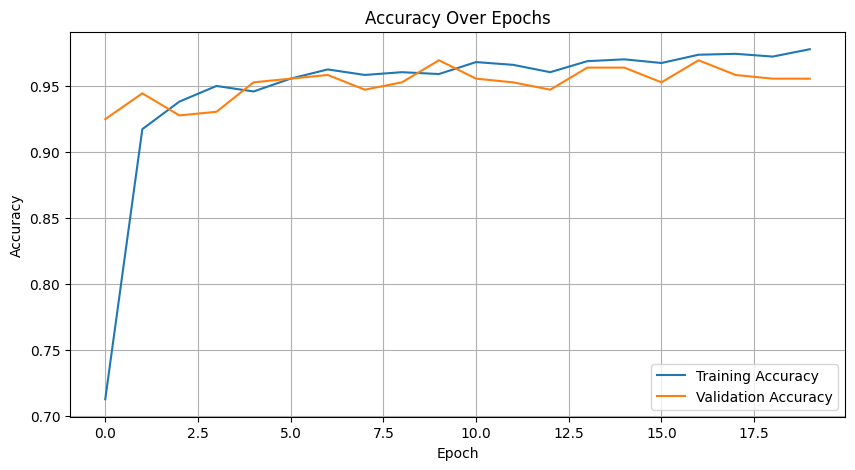

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.title("Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.show()


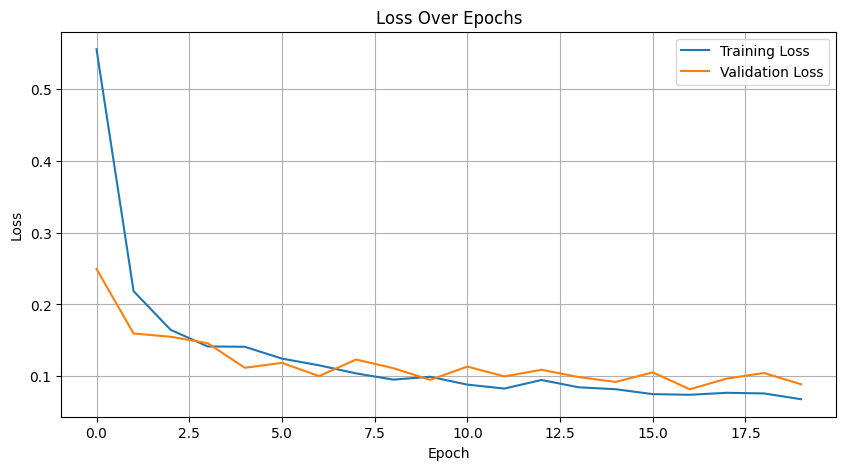

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()


12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 403ms/step


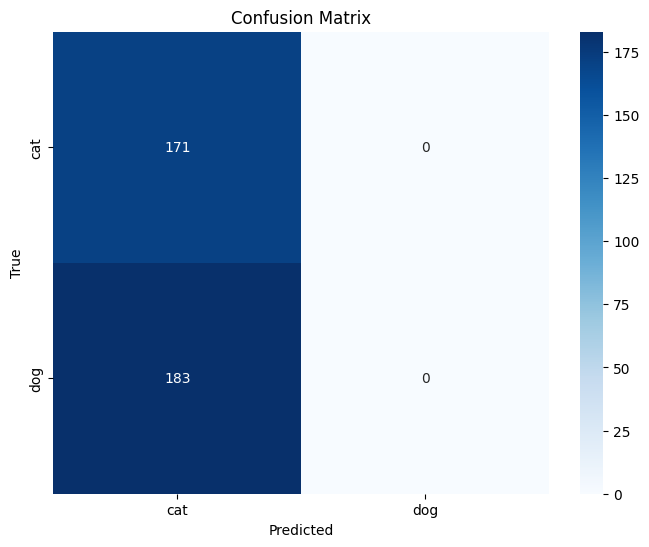

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

true_labels = test_generator.classes
pred_probs = model.predict(test_generator)
pred_labels = np.argmax(pred_probs, axis=1)

cm = confusion_matrix(true_labels, pred_labels)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=test_generator.class_indices.keys(),
            yticklabels=test_generator.class_indices.keys())
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()



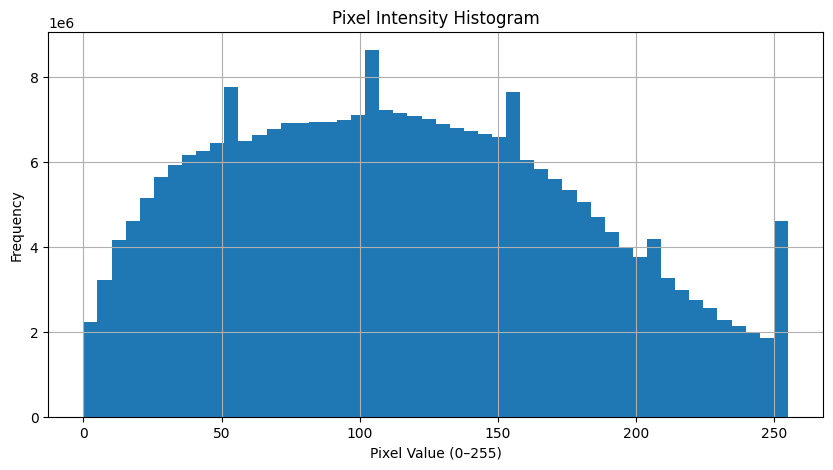

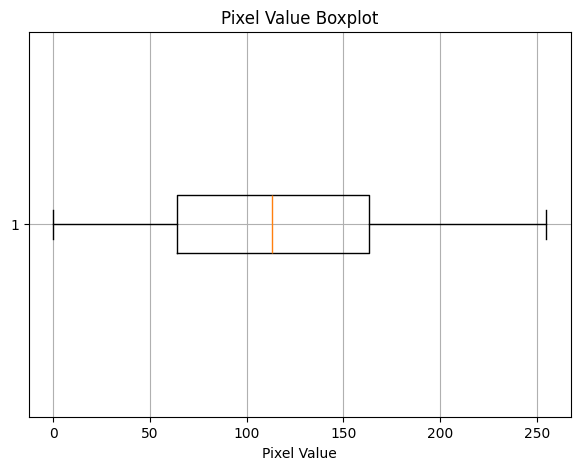

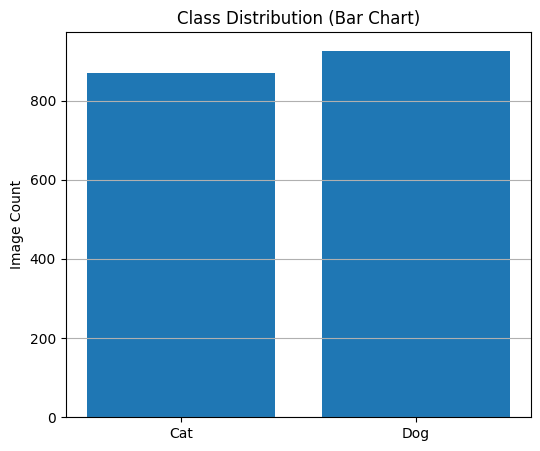

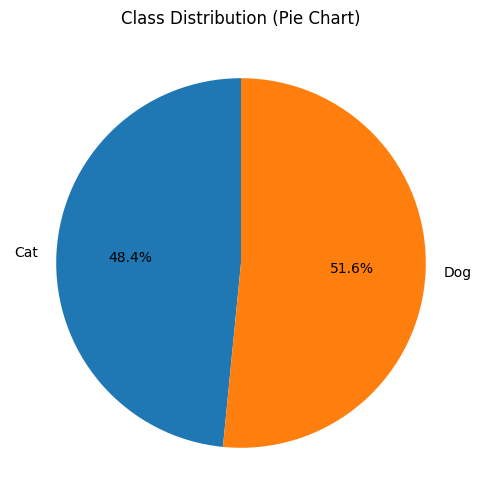

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

# ---- KLASÖR YOLLARINI GÜNCELLE ----

cats = os.path.join(train_dir, "cat")
dogs = os.path.join(train_dir, "dog")

# Tüm resimleri oku ve piksel değerleri listeye ekle
pixel_values = []

def load_images(folder):
    vals = []
    for img_name in os.listdir(folder):
        img_path = os.path.join(folder, img_name)
        img = cv2.imread(img_path)
        if img is not None:
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            vals.extend(gray.flatten())
    return vals

pixel_values.extend(load_images(cats))
pixel_values.extend(load_images(dogs))
pixel_values = np.array(pixel_values)

# ---------------------------------------------
# 1) HISTOGRAM
# ---------------------------------------------
plt.figure(figsize=(10,5))
plt.hist(pixel_values, bins=50)
plt.title("Pixel Intensity Histogram")
plt.xlabel("Pixel Value (0–255)")
plt.ylabel("Frequency")
plt.grid()
plt.show()

# ---------------------------------------------
# 2) BOXPLOT
# ---------------------------------------------
plt.figure(figsize=(7,5))
plt.boxplot(pixel_values, vert=False)
plt.title("Pixel Value Boxplot")
plt.xlabel("Pixel Value")
plt.grid()
plt.show()

# ---------------------------------------------
# 3) BAR CHART (Sınıf sayıları)
# ---------------------------------------------
cat_count = len(os.listdir(cats))
dog_count = len(os.listdir(dogs))

plt.figure(figsize=(6,5))
plt.bar(["Cat", "Dog"], [cat_count, dog_count])
plt.title("Class Distribution (Bar Chart)")
plt.ylabel("Image Count")
plt.grid(axis="y")
plt.show()

# ---------------------------------------------
# 4) PIE CHART
# ---------------------------------------------
plt.figure(figsize=(6,6))
plt.pie([cat_count, dog_count],
        labels=["Cat", "Dog"],
        autopct="%1.1f%%",
        startangle=90)
plt.title("Class Distribution (Pie Chart)")
plt.show()
